In [36]:
import pandas as pd
import numpy as np
import copy
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
curr_dir = os.getcwd()
data_folder = os.path.join(curr_dir, "CT15Mn-111018-150419", "dados_camara.csv")
dataset = pd.read_csv(data_folder)
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\CT15Mn-150818_101018\\dados_camara.csv")#dados mais recentes
#tomtom = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\tomtom_data.csv")
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\periodic_data.csv") #dados periodicos gerados automaticamente
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\dados_old.csv") #dados mais antigos
dataset['unique_id'] = dataset.Zona.astype(str) + '_' + dataset.ID_Espira.astype(str)
dataset['unique_id'] = dataset['unique_id'].str.lower()
dataset_uid = dataset[(dataset["unique_id"] == "22_ct5")]

dataset_uid = dataset_uid.drop(columns=["Zona","Contadores","ID_Espira","unique_id"])
dt2 = copy.deepcopy(dataset_uid)
#dataset.sort_values(['Data'],ascending=True).groupby('Data').reset_index()

dataset_uid = dataset_uid.groupby('Data').apply(lambda x: x.reset_index())

msk = np.random.rand(len(dataset_uid)) < 0.7
train_df = dataset_uid[msk]
test_df = dataset_uid[~msk]





dt2.to_csv("limited_data.csv", sep= ',', index=False)
#train_set
train_df = train_df.drop(columns=["index"])

train_df.to_csv("train.csv", sep= ',', index=False)

#test_set
test_df = test_df.drop(columns=["index"])
test_df.to_csv("test.csv", sep= ',', index=False)

#full set
dataset_uid = dataset_uid.drop(columns=["index"])
dataset_uid.to_csv("dados_nn.csv", sep=',', index=False)



In [44]:
#espira confluente (opcional)
#cmp= espira complementar
cmp_data = dataset[(dataset["unique_id"] == "22_ct2")]
cmp_data = cmp_data.drop(columns=["Zona","Contadores","ID_Espira","unique_id"])
train_cmp_data = cmp_data[cmp_data["Data"].isin(train_df["Data"])]
train_cmp_data = train_cmp_data.groupby('Data').apply(lambda x: x.reset_index())
train_cmp_data = train_cmp_data.drop(columns=["index"])

train_cmp_data.to_csv("train_cmp.csv", sep= ',', index=False)


test_cmp_data = cmp_data[cmp_data["Data"].isin(test_df["Data"])]
test_cmp_data = test_cmp_data.groupby('Data').apply(lambda x: x.reset_index())
test_cmp_data = test_cmp_data.drop(columns=["index"])

test_cmp_data.to_csv("test_cmp.csv", sep= ',', index=False)
#print(cmp_data)

In [37]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
hours = [dt.strftime('%H:%M') for dt in datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), timedelta(minutes=15))]

In [51]:
#smoothing using std_dev and mean
from scipy import stats
import statistics


import numpy as np

train_cp = copy.deepcopy(train_df)
test_cp = copy.deepcopy(test_df)

def smooth_data(train_cp,filename):
    data = train_cp.iloc[:,0]
    print(len(data.values))
    train_cp = train_cp.drop(columns=["Data"])
    train_cp = train_cp.values

    #train_cp = train_cp.astype('float32')

    avg_list = []
    std_list = []
    for i in range(len(train_cp[0])):
        curr_avg = sum(train_cp[:,i])/len(train_cp[:,i])
        avg_list.append(curr_avg)
        std_list.append(statistics.stdev(train_cp[:,i]))
    #FIX sera que e preciso guardar os valores antigos e usá-los para fazer os updates? 
    #agora esta a fazer uma especie de moving average, utilizando os valores novos nos updates seguintes


    
    for row in range(len(train_cp)):
        number_of_changes= 0
        for column in range(len(train_cp[0])):
            if (train_cp[row][column] > (avg_list[column] + 2*std_list[column])):
                old_value = train_cp[row][column]
                if column == 0:
                    previous_t = train_cp[row,-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                if column == 95:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,0]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                else:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                new_value = train_cp[row][column]
        print("Number of changes: " + str(number_of_changes))
                
    new_d = data.values.reshape(len(data.values),1)
    test = np.concatenate((new_d,train_cp),axis=1)
    pd.DataFrame(test).to_csv(str(filename) + ".csv", sep=',', index=False)
    return test, train_cp
smooth_train, df_train= smooth_data(train_cp, "train_2")
smooth_test, df_test = smooth_data(test_cp, "test_2")


train_cmp_cp = copy.deepcopy(train_cmp_data)
test_cmp_cp = copy.deepcopy(test_cmp_data)

smooth_train_cmp, df_train_cmp= smooth_data(train_cmp_cp, "train_cmp_2")
smooth_test_cmp, df_test_cmp= smooth_data(test_cmp_cp, "test_cmp_2")


120
Number of changes: 18
Number of changes: 12
Number of changes: 9
Number of changes: 12
Number of changes: 8
Number of changes: 6
Number of changes: 4
Number of changes: 7
Number of changes: 5
Number of changes: 10
Number of changes: 9
Number of changes: 4
Number of changes: 7
Number of changes: 3
Number of changes: 8
Number of changes: 7
Number of changes: 10
Number of changes: 6
Number of changes: 1
Number of changes: 0
Number of changes: 3
Number of changes: 3
Number of changes: 1
Number of changes: 3
Number of changes: 1
Number of changes: 1
Number of changes: 2
Number of changes: 0
Number of changes: 1
Number of changes: 4
Number of changes: 0
Number of changes: 0
Number of changes: 3
Number of changes: 3
Number of changes: 6
Number of changes: 0
Number of changes: 2
Number of changes: 1
Number of changes: 0
Number of changes: 0
Number of changes: 0
Number of changes: 4
Number of changes: 0
Number of changes: 0
Number of changes: 1
Number of changes: 5
Number of changes: 4
Numb

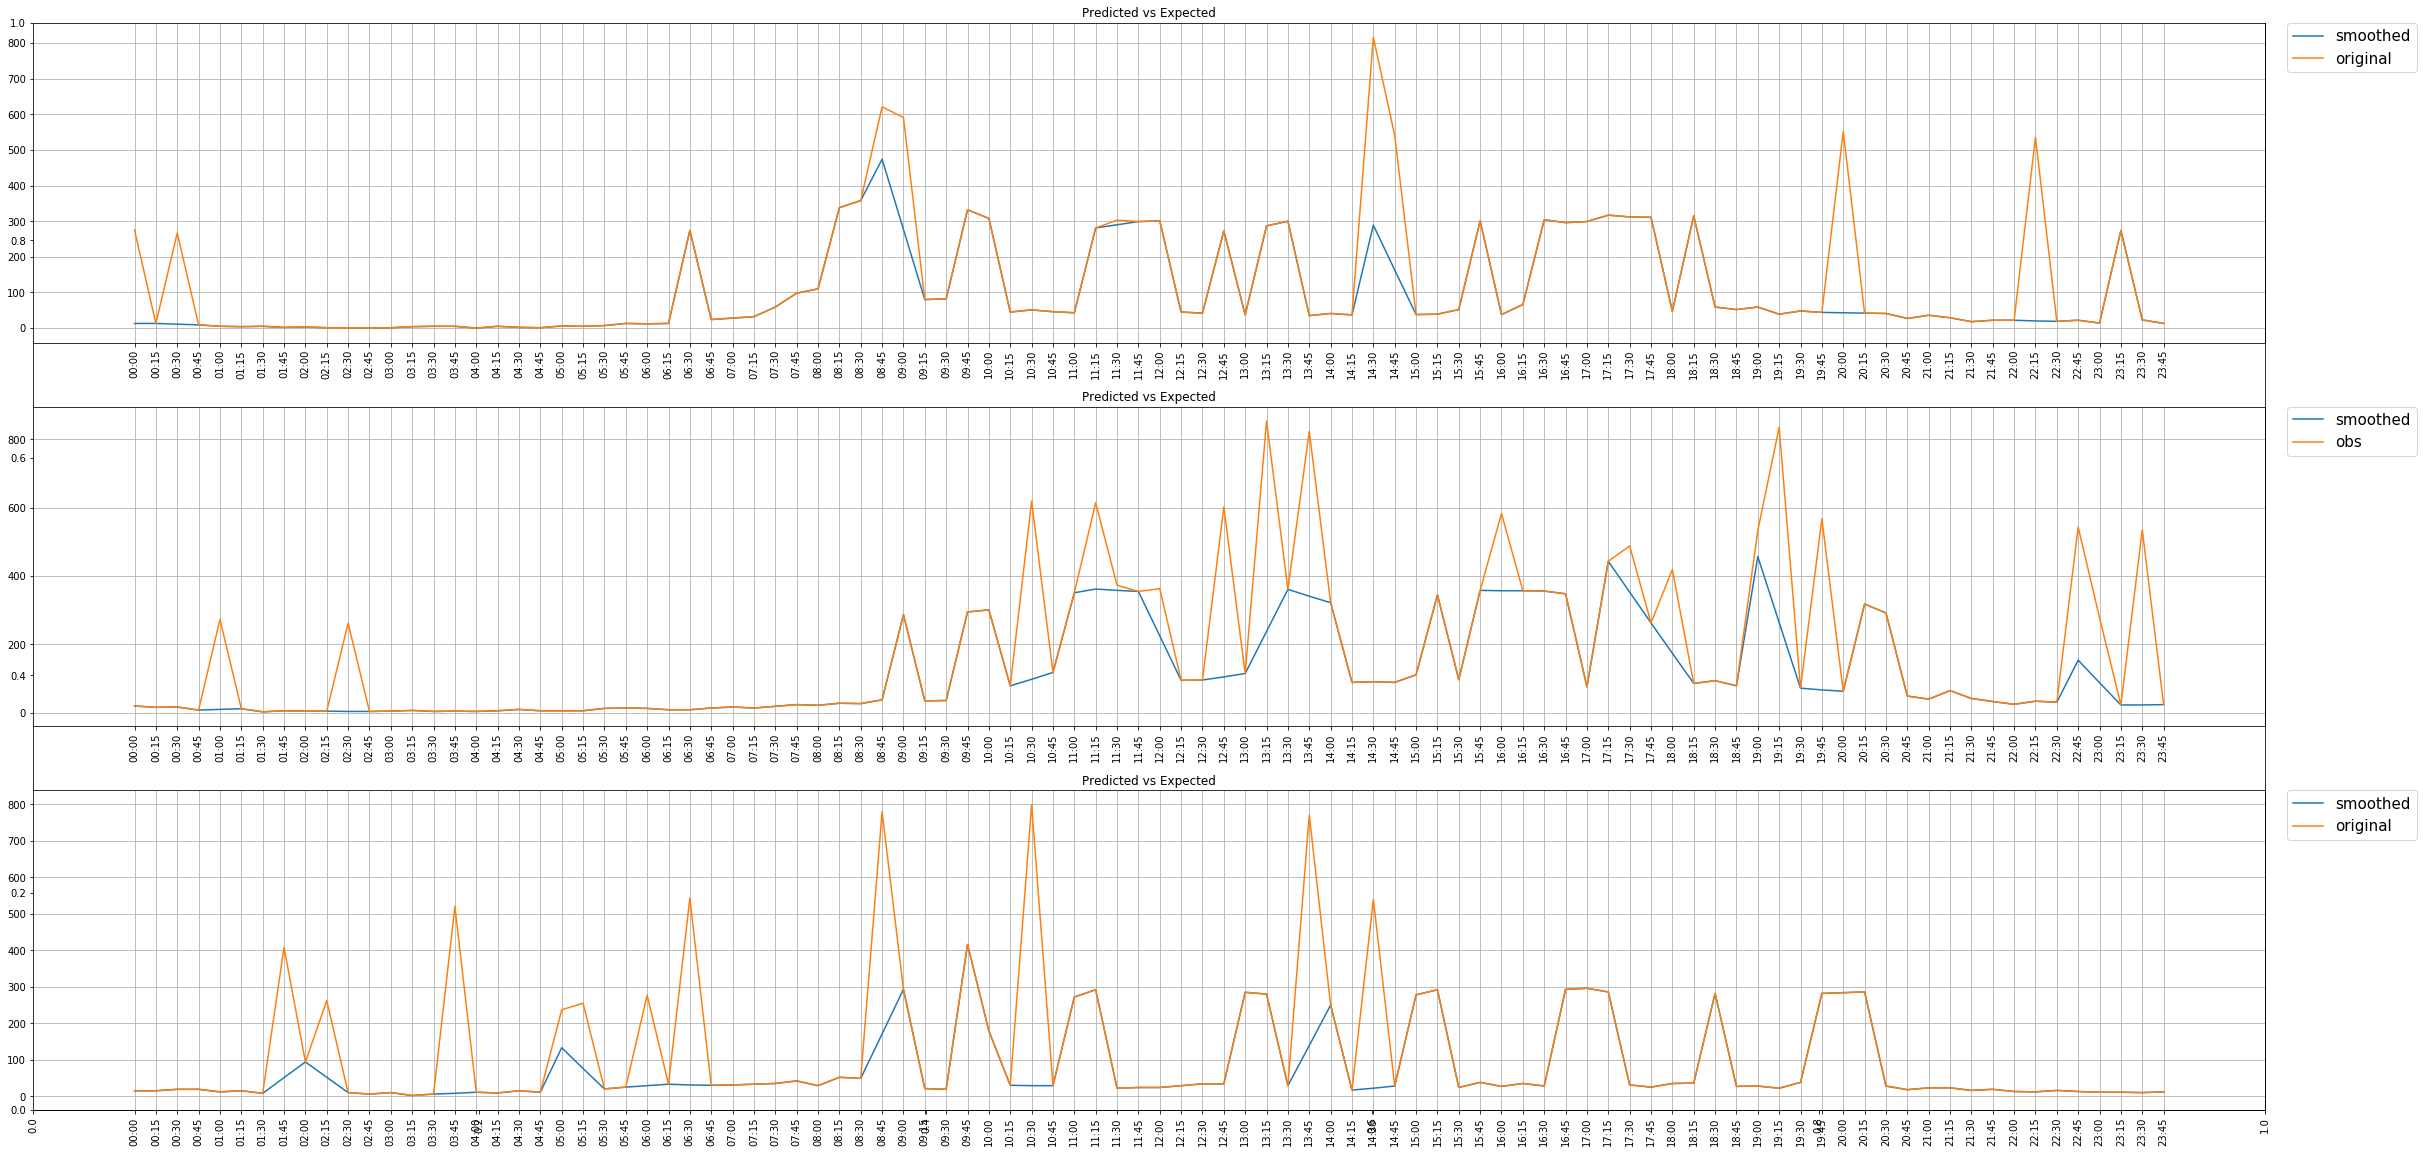

In [52]:
hours = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]


dataframe = pd.read_csv('train.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
train = dataset.astype('float32')

dataframe = pd.read_csv('test.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
test = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
train_cmp = dataset.astype('float32')

def plot_changes(original, smooth):
    fig = plt.figure(3)

    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(hours,smooth[0], label="smoothed")
    ax.plot(hours,original[0], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(312)
    ax.plot(hours,smooth[1], label="smoothed")
    ax.plot(hours,original[1], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(313)
    ax.plot(hours,smooth[2], label="smoothed")
    ax.plot(hours,original[2], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\smoothing\\" +"avg_2stdev_cmp.png", dpi=200)
plot_changes(train_cmp, df_train_cmp)


In [62]:
def transform_data(in_file, out_file, nrows=-1):
    in_file = open(str(in_file),"r")
    next(in_file)
    out_file = open(str(out_file),"w")
    out_file.write("t-3,t-2,t-1,Y\n") #header
    k = 0    
    lines = in_file.readlines()
    for line in lines:
        line = line.split(",")
        line = line[1:]
        line[-1] = line[-1].replace("\n","") #last data record has a \n
        its = [iter(line), iter(line[1:]), iter(line[2:]),iter(line[3:])] #Construct the pattern for longer windowss
        x = list(zip(*its))
        if (k == nrows):
            break
            
        k+=1 
#print(x)
    #j = 0
    #while(j<50): #this cycle was for creating a mock dataset with repeated data for testing purposes
        for i in x:
        #print(i[0],i[1],i[2],i[3])
            out_file.write(i[0] + "," + i[1] +"," + i[2] +","+ i[3])
            out_file.write("\n")
     #   j+=1
    
    in_file.close()
    out_file.close()
transform_data("dados_nn.csv", "new_f.csv")
transform_data("dados_nn.csv", "3day_nn.csv", 3)
transform_data("test_2.csv", "test_formatted.csv")
transform_data("test_2.csv", "3day_unsmoothed.csv",3)
transform_data("train_2.csv", "train_formatted.csv")
transform_data("train_cmp_2.csv", "train_cmp_formatted.csv")
transform_data("train_cmp.csv", "train_cmp_nosmooth.csv")

transform_data("test_cmp_2.csv", "test_cmp_formatted.csv")


In [116]:
###########FREEWAY DATASET############################

def create_dataset2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# load the dataset
dataframe = pd.read_csv('freeway_data1.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# load data
data = train
# create scaler
scaler = StandardScaler()
# fit scaler on data
scaler.fit(data)
# apply transform
normalized = scaler.transform(data)
# inverse transform
inverse = scaler.inverse_transform(normalized)
#print(inverse)
#print(normalized)
f_trainX, f_trainY = create_dataset2(train,3)
f_testX, f_testY =create_dataset2(test,3)



9676 2420


In [65]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import sys

# fix random seed for reproducibility
#numpy.random.seed(7)

#dataframe = pd.read_csv('new_f.csv') #raw data
#dataset = dataframe.values
#dataset = dataset.astype('float32')
#dataframe = pd.read_csv('test.csv') #data generated by reusing the same day 50 times


dataframe = pd.read_csv('train_formatted.csv')
dataset = dataframe.values
train_set = dataset.astype('float32')

dataframe = pd.read_csv('test_formatted.csv')
dataset = dataframe.values
test_set = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp_formatted.csv')
dataset = dataframe.values
train_cmp_set = dataset.astype('float32')

dataframe = pd.read_csv('test_cmp_formatted.csv')
dataset = dataframe.values
test_cmp_set = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp_nosmooth.csv')
dataset = dataframe.values
no_smooth = dataset.astype('float32')


def create_dataset(data):
    X,Y = [],[]
    for i in data:
        X.append(i[:3])
        Y.append(i[3])
    return numpy.array(X), numpy.array(Y)
print(len(train_set))
print(len(test_set))
print(len(train_cmp_set))
trainX, trainY = create_dataset(train_set)

testX, testY = create_dataset(test_set)
trainX_cmp,trainY_cmp = create_dataset(train_cmp_set)

print(trainX)
print(trainX_cmp)

trainX_both = np.concatenate((trainX, trainX_cmp), axis=1)
print(trainX_both)




11160
4092
11160
[[ 42. 290. 162.]
 [290. 162.  35.]
 [162.  35.  22.]
 ...
 [262. 212. 119.]
 [212. 119.  26.]
 [119.  26. 425.]]
[[13. 13. 11.]
 [13. 11.  9.]
 [11.  9.  5.]
 ...
 [11. 15. 11.]
 [15. 11. 11.]
 [11. 11.  8.]]
[[ 42. 290. 162.  13.  13.  11.]
 [290. 162.  35.  13.  11.   9.]
 [162.  35.  22.  11.   9.   5.]
 ...
 [262. 212. 119.  11.  15.  11.]
 [212. 119.  26.  15.  11.  11.]
 [119.  26. 425.  11.  11.   8.]]


In [ ]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import sys


model = Sequential()
layer1 = Dense(64,input_dim=3, activation='relu')
layer2 = Dense(64, activation='relu')
layer3 = Dense(32, activation='relu')
#layer3 = Dense(400, activation='relu')
model.add(layer1)
model.add(layer2)
#model.add(layer2)
#model.add(Dense(8, activation='relu'))
model.add(Dense(1,activation='linear'))
sgd = optimizers.SGD(lr=0.001)

adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='mean_squared_error', optimizer=adam,metrics=['mape', 'mae', 'mse'])
history= model.fit(f_trainX, f_trainY, epochs=450, verbose=1, batch_size=32, validation_split=0.2)

Train on 7737 samples, validate on 1935 samples
Epoch 1/450
7737/7737 [==============================] - 2s 269us/step - loss: 31683.0848 - mean_absolute_percentage_error: 16.6797 - mean_absolute_error: 97.1761 - mean_squared_error: 31683.0848 - val_loss: 10016.3911 - val_mean_absolute_percentage_error: 10.6711 - val_mean_absolute_error: 65.6815 - val_mean_squared_error: 10016.3911
Epoch 2/450
7737/7737 [==============================] - 1s 102us/step - loss: 7283.9717 - mean_absolute_percentage_error: 11.1908 - mean_absolute_error: 57.0572 - mean_squared_error: 7283.9717 - val_loss: 8805.6176 - val_mean_absolute_percentage_error: 10.1194 - val_mean_absolute_error: 61.1158 - val_mean_squared_error: 8805.6176
Epoch 3/450
7737/7737 [==============================] - 1s 101us/step - loss: 7038.9384 - mean_absolute_percentage_error: 11.0687 - mean_absolute_error: 56.1908 - mean_squared_error: 7038.9384 - val_loss: 8832.2561 - val_mean_absolute_percentage_error: 10.1092 - val_mean_absolute_

7737/7737 [==============================] - 1s 90us/step - loss: 7345.6824 - mean_absolute_percentage_error: 11.5123 - mean_absolute_error: 57.4783 - mean_squared_error: 7345.6824 - val_loss: 8732.1539 - val_mean_absolute_percentage_error: 10.3192 - val_mean_absolute_error: 61.2701 - val_mean_squared_error: 8732.1539
Epoch 26/450
7737/7737 [==============================] - 1s 98us/step - loss: 7052.5541 - mean_absolute_percentage_error: 11.4413 - mean_absolute_error: 56.8058 - mean_squared_error: 7052.5541 - val_loss: 8626.1232 - val_mean_absolute_percentage_error: 10.6372 - val_mean_absolute_error: 61.0180 - val_mean_squared_error: 8626.1232
Epoch 27/450
7737/7737 [==============================] - 1s 93us/step - loss: 6948.8485 - mean_absolute_percentage_error: 11.3705 - mean_absolute_error: 56.1018 - mean_squared_error: 6948.8485 - val_loss: 8946.0405 - val_mean_absolute_percentage_error: 10.6643 - val_mean_absolute_error: 61.4679 - val_mean_squared_error: 8946.0405
Epoch 28/450
7

Epoch 50/450
7737/7737 [==============================] - 1s 71us/step - loss: 6744.6588 - mean_absolute_percentage_error: 11.6228 - mean_absolute_error: 55.9729 - mean_squared_error: 6744.6588 - val_loss: 9100.4572 - val_mean_absolute_percentage_error: 10.6804 - val_mean_absolute_error: 61.3739 - val_mean_squared_error: 9100.4572
Epoch 51/450
7737/7737 [==============================] - 1s 85us/step - loss: 7000.9486 - mean_absolute_percentage_error: 11.5865 - mean_absolute_error: 56.5035 - mean_squared_error: 7000.9486 - val_loss: 8749.8068 - val_mean_absolute_percentage_error: 10.4083 - val_mean_absolute_error: 60.5171 - val_mean_squared_error: 8749.8068
Epoch 52/450
7737/7737 [==============================] - 1s 83us/step - loss: 6912.8504 - mean_absolute_percentage_error: 11.6518 - mean_absolute_error: 56.3567 - mean_squared_error: 6912.8504 - val_loss: 8883.3031 - val_mean_absolute_percentage_error: 10.4625 - val_mean_absolute_error: 61.5621 - val_mean_squared_error: 8883.3031
E

Epoch 75/450
7737/7737 [==============================] - 1s 89us/step - loss: 6883.1139 - mean_absolute_percentage_error: 11.7158 - mean_absolute_error: 56.3967 - mean_squared_error: 6883.1139 - val_loss: 8970.9209 - val_mean_absolute_percentage_error: 10.3643 - val_mean_absolute_error: 61.8300 - val_mean_squared_error: 8970.9209
Epoch 76/450
7737/7737 [==============================] - 1s 80us/step - loss: 6814.4462 - mean_absolute_percentage_error: 11.6458 - mean_absolute_error: 56.0995 - mean_squared_error: 6814.4462 - val_loss: 8830.9792 - val_mean_absolute_percentage_error: 10.4267 - val_mean_absolute_error: 60.9818 - val_mean_squared_error: 8830.9792
Epoch 77/450
7737/7737 [==============================] - 1s 69us/step - loss: 6731.8230 - mean_absolute_percentage_error: 11.6059 - mean_absolute_error: 55.7247 - mean_squared_error: 6731.8230 - val_loss: 9976.8263 - val_mean_absolute_percentage_error: 11.3982 - val_mean_absolute_error: 64.9429 - val_mean_squared_error: 9976.8263
E

Epoch 100/450
7737/7737 [==============================] - 1s 84us/step - loss: 6628.3557 - mean_absolute_percentage_error: 11.6643 - mean_absolute_error: 55.6446 - mean_squared_error: 6628.3557 - val_loss: 9008.6459 - val_mean_absolute_percentage_error: 10.3845 - val_mean_absolute_error: 61.3257 - val_mean_squared_error: 9008.6459
Epoch 101/450
7737/7737 [==============================] - 1s 101us/step - loss: 6771.3112 - mean_absolute_percentage_error: 11.6476 - mean_absolute_error: 56.3324 - mean_squared_error: 6771.3112 - val_loss: 9592.5450 - val_mean_absolute_percentage_error: 10.3602 - val_mean_absolute_error: 63.7351 - val_mean_squared_error: 9592.5450
Epoch 102/450
7737/7737 [==============================] - 1s 74us/step - loss: 6791.0504 - mean_absolute_percentage_error: 11.6075 - mean_absolute_error: 56.2060 - mean_squared_error: 6791.0504 - val_loss: 9053.0229 - val_mean_absolute_percentage_error: 10.6788 - val_mean_absolute_error: 60.9690 - val_mean_squared_error: 9053.02

7737/7737 [==============================] - 1s 71us/step - loss: 6813.5258 - mean_absolute_percentage_error: 11.5385 - mean_absolute_error: 56.5197 - mean_squared_error: 6813.5258 - val_loss: 9065.6372 - val_mean_absolute_percentage_error: 10.3705 - val_mean_absolute_error: 61.2779 - val_mean_squared_error: 9065.6372
Epoch 125/450
7737/7737 [==============================] - 1s 71us/step - loss: 6691.9943 - mean_absolute_percentage_error: 11.5012 - mean_absolute_error: 56.0497 - mean_squared_error: 6691.9943 - val_loss: 9156.1027 - val_mean_absolute_percentage_error: 10.2686 - val_mean_absolute_error: 62.1446 - val_mean_squared_error: 9156.1027
Epoch 126/450
7737/7737 [==============================] - 1s 71us/step - loss: 6667.3194 - mean_absolute_percentage_error: 11.4465 - mean_absolute_error: 55.8217 - mean_squared_error: 6667.3194 - val_loss: 9100.8335 - val_mean_absolute_percentage_error: 10.4881 - val_mean_absolute_error: 60.8173 - val_mean_squared_error: 9100.8335
Epoch 127/45

Epoch 149/450
7737/7737 [==============================] - 1s 86us/step - loss: 6593.9307 - mean_absolute_percentage_error: 11.4322 - mean_absolute_error: 55.5160 - mean_squared_error: 6593.9307 - val_loss: 9135.0095 - val_mean_absolute_percentage_error: 10.4328 - val_mean_absolute_error: 62.5810 - val_mean_squared_error: 9135.0095
Epoch 150/450
7737/7737 [==============================] - 1s 91us/step - loss: 6612.1681 - mean_absolute_percentage_error: 11.4572 - mean_absolute_error: 55.7245 - mean_squared_error: 6612.1681 - val_loss: 9301.3053 - val_mean_absolute_percentage_error: 10.4038 - val_mean_absolute_error: 62.2081 - val_mean_squared_error: 9301.3053
Epoch 151/450
7737/7737 [==============================] - 1s 72us/step - loss: 6740.7586 - mean_absolute_percentage_error: 11.4612 - mean_absolute_error: 56.1600 - mean_squared_error: 6740.7586 - val_loss: 8876.7388 - val_mean_absolute_percentage_error: 10.4896 - val_mean_absolute_error: 60.8171 - val_mean_squared_error: 8876.738

7737/7737 [==============================] - 1s 83us/step - loss: 6611.8507 - mean_absolute_percentage_error: 11.5256 - mean_absolute_error: 55.6880 - mean_squared_error: 6611.8507 - val_loss: 9244.7794 - val_mean_absolute_percentage_error: 10.6765 - val_mean_absolute_error: 61.2071 - val_mean_squared_error: 9244.7794
Epoch 174/450
7737/7737 [==============================] - 1s 77us/step - loss: 6616.4947 - mean_absolute_percentage_error: 11.4427 - mean_absolute_error: 55.4904 - mean_squared_error: 6616.4947 - val_loss: 9146.2847 - val_mean_absolute_percentage_error: 10.9413 - val_mean_absolute_error: 61.8634 - val_mean_squared_error: 9146.2847
Epoch 175/450
7737/7737 [==============================] - 1s 72us/step - loss: 6550.7882 - mean_absolute_percentage_error: 11.5522 - mean_absolute_error: 55.7000 - mean_squared_error: 6550.7882 - val_loss: 9119.4111 - val_mean_absolute_percentage_error: 10.7375 - val_mean_absolute_error: 61.4057 - val_mean_squared_error: 9119.4111
Epoch 176/45

Epoch 198/450
7737/7737 [==============================] - 1s 72us/step - loss: 6567.9380 - mean_absolute_percentage_error: 11.4551 - mean_absolute_error: 55.7202 - mean_squared_error: 6567.9380 - val_loss: 9157.7231 - val_mean_absolute_percentage_error: 10.2488 - val_mean_absolute_error: 61.4880 - val_mean_squared_error: 9157.7231
Epoch 199/450
7737/7737 [==============================] - 1s 76us/step - loss: 6644.4736 - mean_absolute_percentage_error: 11.6039 - mean_absolute_error: 56.2983 - mean_squared_error: 6644.4736 - val_loss: 9428.3926 - val_mean_absolute_percentage_error: 10.3257 - val_mean_absolute_error: 63.3506 - val_mean_squared_error: 9428.3926
Epoch 200/450
7737/7737 [==============================] - 1s 82us/step - loss: 6549.7393 - mean_absolute_percentage_error: 11.4008 - mean_absolute_error: 55.5929 - mean_squared_error: 6549.7393 - val_loss: 9098.1511 - val_mean_absolute_percentage_error: 10.2366 - val_mean_absolute_error: 62.0894 - val_mean_squared_error: 9098.151

7737/7737 [==============================] - 1s 115us/step - loss: 6471.3286 - mean_absolute_percentage_error: 11.3558 - mean_absolute_error: 55.1994 - mean_squared_error: 6471.3286 - val_loss: 9133.0169 - val_mean_absolute_percentage_error: 10.6307 - val_mean_absolute_error: 61.3117 - val_mean_squared_error: 9133.0169
Epoch 223/450
7737/7737 [==============================] - 1s 82us/step - loss: 6644.5343 - mean_absolute_percentage_error: 11.5268 - mean_absolute_error: 56.1314 - mean_squared_error: 6644.5343 - val_loss: 9029.3878 - val_mean_absolute_percentage_error: 10.4989 - val_mean_absolute_error: 60.9304 - val_mean_squared_error: 9029.3878
Epoch 224/450
7737/7737 [==============================] - 1s 123us/step - loss: 6523.7931 - mean_absolute_percentage_error: 11.3483 - mean_absolute_error: 55.3572 - mean_squared_error: 6523.7931 - val_loss: 8940.5704 - val_mean_absolute_percentage_error: 10.4891 - val_mean_absolute_error: 60.8591 - val_mean_squared_error: 8940.5704
Epoch 225/

7737/7737 [==============================] - 1s 81us/step - loss: 6613.1491 - mean_absolute_percentage_error: 11.4929 - mean_absolute_error: 55.8539 - mean_squared_error: 6613.1491 - val_loss: 9018.3136 - val_mean_absolute_percentage_error: 10.3440 - val_mean_absolute_error: 62.0807 - val_mean_squared_error: 9018.3136
Epoch 247/450
7737/7737 [==============================] - 1s 74us/step - loss: 6561.9796 - mean_absolute_percentage_error: 11.3954 - mean_absolute_error: 55.3925 - mean_squared_error: 6561.9796 - val_loss: 9438.8859 - val_mean_absolute_percentage_error: 10.2586 - val_mean_absolute_error: 63.4761 - val_mean_squared_error: 9438.8859
Epoch 248/450
7737/7737 [==============================] - 1s 106us/step - loss: 6552.5139 - mean_absolute_percentage_error: 11.2809 - mean_absolute_error: 55.3076 - mean_squared_error: 6552.5139 - val_loss: 9160.1626 - val_mean_absolute_percentage_error: 10.7146 - val_mean_absolute_error: 61.8171 - val_mean_squared_error: 9160.1626
Epoch 249/4

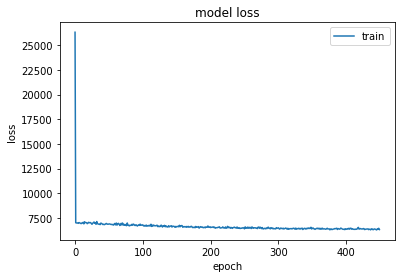

In [119]:
# summarize history for loss
fig = plt.figure(1)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
fig.savefig("adam6.png",dpi=100)

In [20]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
curr_dir = os.getcwd()


obs_df = pd.read_csv('3day_unsmoothed.csv')
obs = obs_df.values
obs = obs.astype('float32')

obsX, obsY = create_dataset(obs)
#print(obsX)
pred = model.predict(obsX)
#print(pred)
#print(obsY)

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 45), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]
print(len(pred[93:186]))
print(len(pred[186:279]))

#sys.exit()
#Esta feito para um gráfico ao longo de três dias 
def plot_results(dts, pred, obsY, plot_name):
    fig = plt.figure(2)
    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(dts,pred[0:93], label="pred")
    ax.plot(dts,obsY[0:93], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax2 = fig.add_subplot(312)
    ax2.plot(dts, pred[93:186], label="pred")
    ax2.plot(dts,obsY[93:186], label="obs")
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax2.grid(True)
    ax2.set_title("Predicted vs Expected")
    ax2.tick_params(axis='x', rotation=90)

    ax3 = fig.add_subplot(313)
    ax3.plot(dts, pred[186:279], label="pred")
    ax3.plot(dts,obsY[186:279], label="obs")
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax3.grid(True)
    ax3.set_title("Predicted vs Expected")
    ax3.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\results_nn\\" +str(plot_name)+".png", dpi=100)
plot_results(dts, pred, obsY, "linear_reg")

#plot_changes(test, df_test)

NameError: name 'create_dataset' is not defined

96


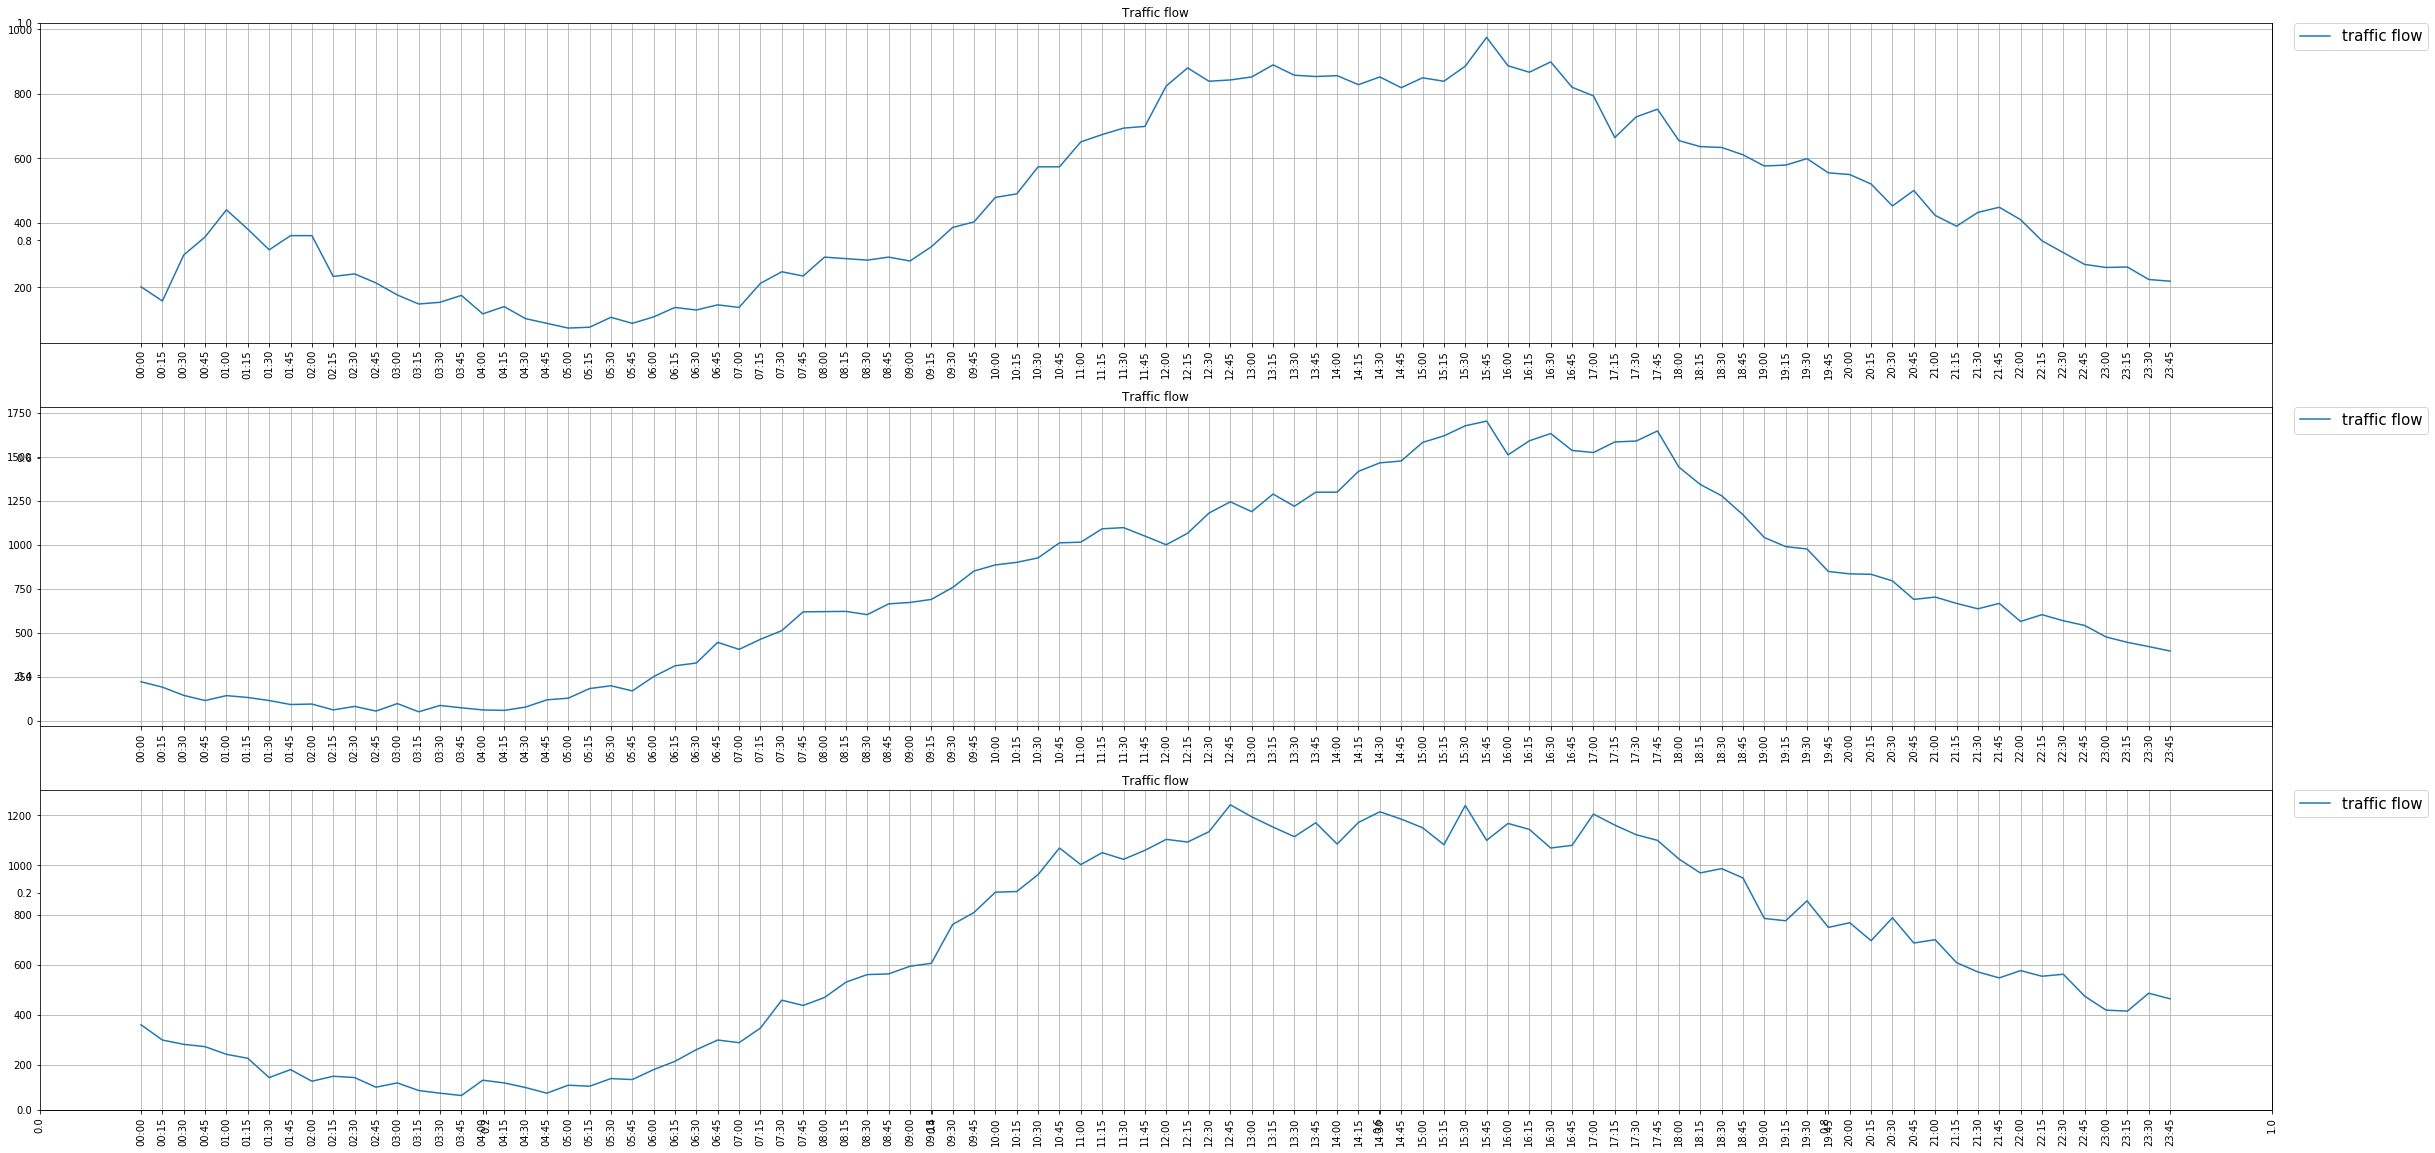

In [89]:
def plot_freeway(hours):
    dataframe = pd.read_csv('freeway_data1.csv', usecols=[1], engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    
  
    fig = plt.figure(4)
    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(dts,dataset[0:96], label="traffic flow")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Traffic flow")
    ax.tick_params(axis='x', rotation=90)

    ax2 = fig.add_subplot(312)
    ax2.plot(dts, dataset[96:192], label="traffic flow")
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax2.grid(True)
    ax2.set_title("Traffic flow")
    ax2.tick_params(axis='x', rotation=90)

    ax3 = fig.add_subplot(313)
    ax3.plot(dts, dataset[192:288], label="traffic flow")
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax3.grid(True)
    ax3.set_title("Traffic flow")
    ax3.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig("freeway_data"+".png", dpi=100)
    
# load the dataset
dts = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]
print(len(dts))

plot_freeway(dts)



        

In [107]:
import math

# Estimate model performance
trainScore = model.evaluate(f_trainX, f_trainY, verbose=0)
print(model.metrics_names)
print(trainScore)
#print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
#testScore = model.evaluate(testX, testY, verbose=0)
#print(testScore)

#print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
def predict_comparison(model, f_trainX, f_trainY,scaler):
    trainPredict = model.predict(f_trainX)
    #print(trainPredict.shape)
    inverse = scaler.inverse_transform(trainPredict)
    #print(inverse)
    f_trainY= f_trainY[:,None]
    ive = scaler.inverse_transform(f_trainY)
    #print(ive)
    print(ive[603])
    predict_comparison(model, f_trainX, f_trainY,scaler)
mape = []
for i in range(len(trainPredict)):
    err = abs(trainPredict[i]-f_trainY[i])/abs(f_trainY[i])
    if err > 1000:
        #print(err)
        #print(i)
        #print(trainPredict[i])
        #print(f_trainY[i])
        break
    #print(err)
    mape.append(err)
print(sum(mape)/(len(mape)))
#testPredict = model.predict(testX)
#print(trainPredict)
#print(trainY)
#print(testPredict)
#print(testY)
layers_conf = []
units = []
activation = []

    


['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error']
[0.021324108873175825, 4325.577417892696, 0.09707361081348558, 0.021324108873175825]
[1.9574766]


In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i].get_config()
    layers_conf.append(layer)
    units.append(layer["units"])
    activation.append(layer["activation"])
    #print(layer["units"])
    #print(layer["activation"])
if (os.stat("metrics_comparison.txt").st_size == 0):
    f = open("metrics_comparison.txt", "w+")
    f.write("N_layers,[units per layer], [activations]," + "\n")
    f.write("Metrics names: "  + str(model.metrics_names)+ "\n\n")
    
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()
else:
    f = open("metrics_comparison.txt", "a+")
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()

In [40]:

#smoothing using z_score
#not great
from scipy import stats

import numpy as np

date = copy.deepcopy(train2.iloc[:,0])
values = copy.deepcopy(train2.iloc[:,1:])
cenas = values.values

z = np.abs(stats.zscore(values))
y = np.abs(stats.zscore(cenas))
threshold = 2
z_score = np.where(y > 3)
#print(cenas[1])
#print(cenas[1,-2])
#print(train2.columns[9])
#z_score doesnt really work very well
for i in z_score[0]:
    for j in z_score[1]:
        #dois casos especiais : 0h00 e 23h45
        if j == 0:
            #values.columns[j] == "0h00":
            #dostuff
            previous_t = cenas[i,-1]
            
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
        if j == 95:
            #dostuff
            next_t = cenas[i,0]
            previous_t = cenas[i,j-1]
            cenas[i,j] = (previous_t + next_t)/2
        else:
            previous_t = cenas[i,j-1]
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
            #values.loc[i,values.columns[j]] = (previous_t + next_t)/2


In [95]:
print(abs(-124234))
#print(dt2.head(10))
# split into train and test sets
#train_size = int(len(dt2) * 0.8)
#test_size = len(dt2) - train_size
#train, test = dt2[0:train_size,:], dt2[train_size:len(dt2),:]


#train2 = copy.deepcopy(train)
#for column in dt2:
#    if column == "Data":
#        continue
#    else:
#        mean = dt2[column].mean()
#        stdev = dt2[column].std()
#        dt2.loc[dt2[column] > (mean + 2*stdev), column] = mean
        
    
#train_size = int(len(dataset) * 0.8)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# split into train and test sets

#print(layer2.get_weights())

124234
